이미지 세그멘테이션 프로젝트를 위해 단계별로 구현 계획을 세웠습니다. 각 단계에 따라 코드를 구현하겠습니다.

### 1. 데이터 준비 및 전처리
- **압축 해제**: `mini_data.zip` 파일의 내용을 압축 해제하고 파일 구조를 확인합니다.
- **데이터 분리**: 이미지와 마스크를 연결하는 CSV 파일을 사용하여 이미지와 해당 마스크를 매칭하고, 이를 훈련 데이터와 검증 데이터로 9:1 비율로 분리합니다.

### 2. 모델 구성
- **신경망 선택**: U-Net, FCN, SegNet 아키텍처를 구현하고, ResNet, VGG, EfficientNet을 각각의 백본으로 사용합니다.
- **모델 정의**: 각 신경망에 맞게 모델을 정의하고 PyTorch에서 사용할 수 있도록 설정합니다.

### 3. 훈련 및 검증
- **손실 함수 및 최적화**: Dice Coefficient 손실 함수를 사용하고, 옵티마이저로는 Adam을 선택합니다.
- **지표 계산**: 각 에포크마다 Dice Coefficient와 IOU를 계산합니다.
- **로그 저장**: 훈련 중 각 에포크의 결과를 "신경망이름_현재시간.csv"로 저장합니다.
- **모델 저장**: 각 신경망의 가장 좋은 모델을 "신경망이름_현재시간.pth" 파일로 저장합니다.

### 4. 결과 분석 및 시각화
- **손실 및 지표 그래프**: LOSS, Dice, IOU 값을 시각화하여 그래프로 나타냅니다.
- **인터랙티브 시각화**: Jupyter Notebook에서 입력 이미지, 입력 마스크, 예측 마스크를 비교할 수 있도록 시각화 합니다.

### 5. 실행 및 검증
- **모델 로드**: 훈련된 모델을 로드하고, 검증 데이터를 사용하여 모델 성능을 평가합니다.
- **결과 검증**: 시각적으로 결과를 검증하고 모델의 성능을 평가합니다.

이 계획에 따라 코드를 구현하겠습니다. 우선, `mini_data.zip` 파일을 압축 해제하고 데이터 구조를 확인한 다음, 데이터를 분리하는 코드부터 작성하겠습니다.

In [57]:
import os
import pandas as pd

data_path = '../DataSet/BeadSegmentation/'
# train.csv 파일 경로
csv_path = os.path.join(data_path, 'mini_data', 'train.csv')

# CSV 파일 로드
data_df = pd.read_csv(csv_path)
data_df.head()


,ImageId,MaskId
0,20230930_21h03m03s_B01_1.png,20230930_21h03m03s_B01_1_mask.png
1,20230930_21h03m03s_B01_2.png,20230930_21h03m03s_B01_2_mask.png
2,20230930_21h03m06s_B02_1.png,20230930_21h03m06s_B02_1_mask.png
3,20230930_21h03m06s_B02_2.png,20230930_21h03m06s_B02_2_mask.png
4,20230930_21h03m06s_B02_3.png,20230930_21h03m06s_B02_3_mask.png


### 데이터 분리 단계
- **데이터셋 셔플링**: 데이터를 무작위로 섞어서 모델이 특정 순서에 의존하지 않도록 합니다.
- **분리**: 전체 데이터셋을 90%는 훈련용으로, 나머지 10%는 검증용으로 분리합니다.
- **파일 저장**: 분리된 데이터를 각각의 폴더(훈련 및 검증)에 저장합니다.

In [58]:
from sklearn.model_selection import train_test_split

# 데이터셋을 훈련용과 검증용으로 분리 (90% 훈련, 10% 검증)
train_df, val_df = train_test_split(data_df, test_size=0.1, random_state=42)

# 훈련용과 검증용 데이터 프레임 확인
train_df.head(), val_df.head(), len(train_df), len(val_df)


(                         ImageId                             MaskId
 37  20230930_21h03m42s_B11_2.png  20230930_21h03m42s_B11_2_mask.png
 12  20230930_21h03m13s_B04_3.png  20230930_21h03m13s_B04_3_mask.png
 19  20230930_21h03m20s_B06_2.png  20230930_21h03m20s_B06_2_mask.png
 4   20230930_21h03m06s_B02_3.png  20230930_21h03m06s_B02_3_mask.png
 25  20230930_21h03m31s_B08_2.png  20230930_21h03m31s_B08_2_mask.png,
                          ImageId                             MaskId
 27  20230930_21h03m31s_B08_4.png  20230930_21h03m31s_B08_4_mask.png
 40  20230930_21h03m46s_B12_1.png  20230930_21h03m46s_B12_1_mask.png
 26  20230930_21h03m31s_B08_3.png  20230930_21h03m31s_B08_3_mask.png
 43  20230930_21h03m46s_B12_4.png  20230930_21h03m46s_B12_4_mask.png
 24  20230930_21h03m31s_B08_1.png  20230930_21h03m31s_B08_1_mask.png,
 43,
 5)

### 데이터셋 폴더 셋업

In [59]:
import os
import shutil

# 데이터 세트 유형 선택 ('mini_data' 또는 'original_data')
data_type = 'mini_data'  # 또는 'original_data'

# 데이터셋 경로 설정
dataset_path = os.path.join(data_path, data_type)

# 훈련 및 검증 데이터 폴더 생성
train_dir = os.path.join(data_path, 'train')
val_dir = os.path.join(data_path, 'val')

# 훈련 및 검증 폴더 내의 이미지와 마스크 폴더 생성
train_img_dir = os.path.join(train_dir, 'images')
train_mask_dir = os.path.join(train_dir, 'masks')
val_img_dir = os.path.join(val_dir, 'images')
val_mask_dir = os.path.join(val_dir, 'masks')

# 기존 폴더가 있을 경우 삭제
for dir_path in [train_dir, val_dir]:
    if os.path.exists(dir_path):
        shutil.rmtree(dir_path)
    os.makedirs(dir_path)

# 이미지와 마스크 폴더 생성
for sub_dir in [train_img_dir, train_mask_dir, val_img_dir, val_mask_dir]:
    os.makedirs(sub_dir)

# 훈련용 데이터 복사
for idx, row in train_df.iterrows():
    # 원본 이미지와 마스크 경로
    src_image_path = os.path.join(dataset_path, 'images', row['ImageId'])
    src_mask_path = os.path.join(dataset_path, 'masks', row['MaskId'])
    # 대상 이미지와 마스크 경로
    dst_image_path = os.path.join(train_img_dir, row['ImageId'])
    dst_mask_path = os.path.join(train_mask_dir, row['MaskId'])
    
    # 파일 복사
    shutil.copy(src_image_path, dst_image_path)
    shutil.copy(src_mask_path, dst_mask_path)

# 검증용 데이터 복사
for idx, row in val_df.iterrows():
    # 원본 이미지와 마스크 경로
    src_image_path = os.path.join(dataset_path, 'images', row['ImageId'])
    src_mask_path = os.path.join(dataset_path, 'masks', row['MaskId'])
    # 대상 이미지와 마스크 경로
    dst_image_path = os.path.join(val_img_dir, row['ImageId'])
    dst_mask_path = os.path.join(val_mask_dir, row['MaskId'])
    
    # 파일 복사
    shutil.copy(src_image_path, dst_image_path)
    shutil.copy(src_mask_path, dst_mask_path)

# 확인
os.listdir(train_img_dir), os.listdir(train_mask_dir), os.listdir(val_img_dir), os.listdir(val_mask_dir)


(['20230930_21h03m13s_B04_2.png',
  '20230930_21h03m13s_B04_4.png',
  '20230930_21h03m20s_B06_3.png',
  '20230930_21h03m50s_B13_2.png',
  '20230930_21h03m35s_B09_1.png',
  '20230930_21h03m35s_B09_3.png',
  '20230930_21h03m06s_B02_3.png',
  '20230930_21h03m39s_B10_3.png',
  '20230930_21h03m09s_B03_3.png',
  '20230930_21h03m50s_B13_3.png',
  '20230930_21h03m46s_B12_3.png',
  '20230930_21h03m06s_B02_4.png',
  '20230930_21h03m42s_B11_1.png',
  '20230930_21h03m20s_B06_4.png',
  '20230930_21h03m39s_B10_2.png',
  '20230930_21h03m06s_B02_1.png',
  '20230930_21h03m20s_B06_1.png',
  '20230930_21h03m50s_B13_1.png',
  '20230930_21h03m42s_B11_3.png',
  '20230930_21h03m09s_B03_2.png',
  '20230930_21h03m06s_B02_2.png',
  '20230930_21h03m42s_B11_4.png',
  '20230930_21h03m35s_B09_2.png',
  '20230930_21h03m03s_B01_2.png',
  '20230930_21h03m16s_B05_4.png',
  '20230930_21h03m13s_B04_1.png',
  '20230930_21h03m35s_B09_4.png',
  '20230930_21h03m42s_B11_2.png',
  '20230930_21h03m16s_B05_3.png',
  '20230930_21

### 손실 함수 정의
손실 함수는 실제 마스크와 예측 마스크 간의 유사도를 Dice로 계산하고, 이진 분류 손실을 BCE로 계산하여 더합니다. 이는 모델이 배경과 전경을 보다 정확히 분리할 수 있도록 도와줍니다.
- **Dice Loss**: 주로 사용되는 세그멘테이션 손실 함수 중 하나로, 예측된 마스크와 실제 마스크 사이의 유사도를 측정합니다.
- **Binary Cross Entropy Loss**: 픽셀 수준에서 실제 값과 예측 값 사이의 차이를 계산합니다.
- **결합 손실 함수**: 이 두 손실을 결합하여 최종 손실을 계산합니다.

In [60]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DiceBCELoss(nn.Module):
    def __init__(self):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        # 입력과 타겟은 [N, 1, H, W] 형태로 가정합니다.
        # inputs -> 모델의 sigmoid 출력 결과
        inputs = torch.sigmoid(inputs)
        
        # Flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        # Dice Loss
        intersection = (inputs * targets).sum()                            
        dice_loss = 1 - (2.*intersection + smooth) / (inputs.sum() + targets.sum() + smooth)  
        
        # Binary Cross Entropy Loss
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        
        # 결합된 손실
        Dice_BCE = BCE + dice_loss
        
        return Dice_BCE


### 모델 정의 및 훈련
- **모델 아키텍처 정의**: U-Net, FCN, SegNet에 대한 아키텍처를 정의하고, ResNet, VGG, EfficientNet을 백본으로 선택할 수 있게 설정합니다.
- **손실 함수 및 최적화**: Dice Coefficient를 손실 함수로 사용하고, SGD와 Adam 중에서 옵티마이저를 선택할 수 있게 설정합니다.
- **훈련 루프**: 지정된 에포크 수(30 에포크) 동안 모델을 훈련하고 각 에포크의 결과를 기록합니다.
- **성능 지표 기록**: 훈련 동안 Dice Coefficient와 IOU 지표를 계산하여 기록합니다.

### 모델 학습 준비
1. **이미지와 마스크 로딩**: PyTorch에서는 `Dataset` 클래스를 사용하여 이미지와 해당 마스크를 로드하고, 필요한 변환(예: 정규화, 크기 조정)을 적용합니다.
2. **이진 분류 세팅**: 마스크는 이진 형식이므로, 모델의 출력 채널은 1로 설정합니다(클래스가 하나뿐이므로). 
3. **손실 함수 설정**: Dice Coefficient는 이진 세그멘테이션에 적합한 손실 함수입니다. 추가적으로, 배경과 세그멘테이션 대상의 불균형을 조정하기 위해 Binary Cross Entropy (BCE)와 결합할 수 있습니다.

### 데이터 로딩 및 변환 구현
- PyTorch의 `torchvision.transforms`를 사용하여 입력 이미지와 마스크에 대한 전처리를 설정합니다.
- 이미지는 RGB 채널을 사용하고, 마스크는 그레이스케일로 처리합니다.
- 데이터 로더(`DataLoader`)를 사용하여 배치 처리를 구성합니다.

### 모델 아키텍처 설정
- 백본 네트워크로 ResNet, VGG, EfficientNet 중 선택 가능하게 구성합니다.
- 주요 세그멘테이션 아키텍처로 U-Net, FCN, SegNet을 구현합니다. 이들 각각에 대해 백본 네트워크를 적용하는 방법을 구성합니다.

In [61]:
import numpy as np
import cv2
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

class SegmentationDataset(Dataset):
    def __init__(self, df, image_dir, mask_dir, transform=None):
        """
        Args:
            df (DataFrame): 이미지와 마스크의 파일 이름을 포함하는 데이터프레임.
            image_dir (string): 이미지 파일의 디렉토리 경로.
            mask_dir (string): 마스크 파일의 디렉토리 경로.
            transform (callable, optional): 샘플에 적용할 선택적 변형.
        """
        self.df = df
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # 이미지 파일과 마스크 파일 경로
        img_name = os.path.join(self.image_dir, self.df.iloc[idx, 0])
        mask_name = os.path.join(self.mask_dir, self.df.iloc[idx, 1])
        
        # 이미지와 마스크 로딩
        image = cv2.imread(img_name)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(mask_name, cv2.IMREAD_GRAYSCALE)
        
        # 히스토그램 평활화 적용
        if self.transform:
            image = self.transform(image)

        # 마스크는 픽셀 값이 0과 255로 이진화
        mask = (mask > 128).astype(np.float32)

        return image, mask

# 데이터셋 트랜스폼 설정
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 데이터셋 및 데이터 로더 생성
train_dataset = SegmentationDataset(train_df, train_img_dir, train_mask_dir, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4)

# 검증 데이터셋과 데이터 로더 설정
val_dataset = SegmentationDataset(val_df, val_img_dir, val_mask_dir, transform=transform)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=4)


### 1. Resnet을 백본으로 사용하는 U-Net 모델 구성

In [77]:
import torch
import torch.nn as nn
from torchvision import models

class ResUNet(nn.Module):
    def __init__(self, backbone='resnet', pretrained=True, num_classes=1):
        super(ResUNet, self).__init__()
        if backbone == 'resnet':
            self.base_model = models.resnet34(pretrained=pretrained)
            self.base_layers = list(self.base_model.children())
            self.layer1 = nn.Sequential(*self.base_layers[:3])  # size=(N, 64, H/2, W/2)
            self.layer2 = nn.Sequential(*self.base_layers[3:5])  # size=(N, 128, H/4, W/4)
            self.layer3 = self.base_layers[5]  # size=(N, 256, H/8, W/8)
            self.layer4 = self.base_layers[6]  # size=(N, 512, H/16, W/16)

            # 확장 경로
            self.up1 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
            self.conv_up1 = nn.Conv2d(512, 256, kernel_size=3, padding=1)  # 변경: 입력 채널을 512로 변경
            self.up2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
            self.conv_up2 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
            self.up3 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
            self.conv_up3 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
            self.up4 = nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2)
            self.final_conv = nn.Conv2d(64, num_classes, kernel_size=1)
        
    def forward(self, x):
        # 계약 경로
        x1 = self.layer1(x)
        x2 = self.layer2(x1)
        x3 = self.layer3(x2)
        x4 = self.layer4(x3)

        # 확장 경로 + skip connection
        x = self.up1(x4)
        x = torch.cat([x, x3], dim=1)  # Skip connection
        x = self.conv_up1(x)
        x = self.up2(x)
        x = torch.cat([x, x2], dim=1)
        x = self.conv_up2(x)
        x = self.up3(x)
        x = torch.cat([x, x1], dim=1)
        x = self.conv_up3(x)
        x = self.up4(x)
        x = self.final_conv(x)
        return x


# class ResUNet(nn.Module):
#     def __init__(self, backbone='resnet', pretrained=True, num_classes=1):
#         super(ResUNet, self).__init__()
#         if backbone == 'resnet':
#             self.base_model = models.resnet34(pretrained=pretrained)
#             self.base_layers = list(self.base_model.children())
#             self.layer1 = nn.Sequential(*self.base_layers[:3])  # size=(N, 64, H/2, W/2)
#             self.layer2 = nn.Sequential(*self.base_layers[3:5])  # size=(N, 128, H/4, W/4)
#             self.layer3 = self.base_layers[5]  # size=(N, 256, H/8, W/8)
#             self.layer4 = self.base_layers[6]  # size=(N, 512, H/16, W/16)

#             # 확장 경로
#             self.up1 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
#             self.conv_up1 = nn.Conv2d(512, 256, kernel_size=3, padding=1)
#             self.up2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
#             self.conv_up2 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
#             self.up3 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
#             self.conv_up3 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
#             self.up4 = nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2)
#             self.final_conv = nn.Conv2d(64, num_classes, kernel_size=1)
        
#     def forward(self, x):
#         # 계약 경로
#         x1 = self.layer1(x)
#         x2 = self.layer2(x1)
#         x3 = self.layer3(x2)
#         x4 = self.layer4(x3)

#         # 확장 경로 + skip connection
#         x = self.up1(x4)
#         x = torch.cat([x, x3], dim=1)
#         x = self.conv_up1(x)
#         x = self.up2(x)
#         x = torch.cat([x, x2], dim=1)
#         x = self.conv_up2(x)
#         x = self.up3(x)
#         x = torch.cat([x, x1], dim=1)
#         x = self.conv_up3(x)
#         x = self.up4(x)
#         x = self.final_conv(x)
#         return x


In [63]:
# 데이터 로더 및 모델 인스턴스화

model = ResUNet(backbone='resnet', pretrained=True, num_classes=1)

/home/club8080/.pyenv/versions/3.11.5/envs/my_proj_env/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/club8080/.pyenv/versions/3.11.5/envs/my_proj_env/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### 2.VGG 백본을 사용하는 U-Net 모델 구성

In [64]:
class VGGUNet(nn.Module):
    def __init__(self, num_classes=1, pretrained=True):
        super(VGGUNet, self).__init__()
        self.base_model = models.vgg16(pretrained=pretrained).features
        self.encoder1 = self.base_model[:5]   # 64
        self.encoder2 = self.base_model[5:10] # 128
        self.encoder3 = self.base_model[10:17] # 256
        self.encoder4 = self.base_model[17:24] # 512
        self.encoder5 = self.base_model[24:] # 512

        self.upconv5 = nn.ConvTranspose2d(512, 512, kernel_size=2, stride=2)
        self.conv_decode5 = nn.Conv2d(1024, 512, kernel_size=3, padding=1)
        
        self.upconv4 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.conv_decode4 = nn.Conv2d(512, 256, kernel_size=3, padding=1)
        
        self.upconv3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.conv_decode3 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        
        self.upconv2 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.conv_decode2 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        
        self.upconv1 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.final_conv = nn.Conv2d(32, num_classes, kernel_size=1)

    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(enc1)
        enc3 = self.encoder3(enc2)
        enc4 = self.encoder4(enc3)
        enc5 = self.encoder5(enc4)

        up5 = self.upconv5(enc5)
        dec5 = torch.cat([up5, enc4], dim=1)
        dec5 = self.conv_decode5(dec5)
        
        up4 = self.upconv4(dec5)
        dec4 = torch.cat([up4, enc3], dim=1)
        dec4 = self.conv_decode4(dec4)
        
        up3 = self.upconv3(dec4)
        dec3 = torch.cat([up3, enc2], dim=1)
        dec3 = self.conv_decode3(dec3)
        
        up2 = self.upconv2(dec3)
        dec2 = torch.cat([up2, enc1], dim=1)
        dec2 = self.conv_decode2(dec2)
        
        up1 = self.upconv1(dec2)
        return self.final_conv(up1)


### 3.EfficientNet 백본을 사용하는 U-Net 모델 구성


In [65]:
from efficientnet_pytorch import EfficientNet

class EfficientNetUNet(nn.Module):
    def __init__(self, num_classes=1, pretrained=True):
        super(EfficientNetUNet, self).__init__()
        self.base_model = EfficientNet.from_pretrained('efficientnet-b0')
        self.encoder_blocks = list(self.base_model.children())[0]

        self.upconv5 = nn.ConvTranspose2d(1280, 112, kernel_size=2, stride=2)
        self.conv_decode5 = nn.Conv2d(112 + 320, 112, kernel_size=3, padding=1)
        
        self.upconv4 = nn.ConvTranspose2d(112, 40, kernel_size=2, stride=2)
        self.conv_decode4 = nn.Conv2d(40 + 48, 40, kernel_size=3, padding=1)
        
        self.upconv3 = nn.ConvTranspose2d(40, 24, kernel_size=2, stride=2)
        self.conv_decode3 = nn.Conv2d(24 + 32, 24, kernel_size=3, padding=1)
        
        self.upconv2 = nn.ConvTranspose2d(24, 16, kernel_size=2, stride=2)
        self.conv_decode2 = nn.Conv2d(16 + 24, 16, kernel_size=3, padding=1)
        
        self.upconv1 = nn.ConvTranspose2d(16, 8, kernel_size=2, stride=2)
        self.final_conv = nn.Conv2d(8, num_classes, kernel_size=1)

    def forward(self, x):
        # EfficientNet의 각 블록 출력
        x_skip = []
        x = self.base_model._conv_stem(x)
        x = self.base_model._bn0(x)
        x = self.base_model._swish(x)
        
        for idx, block in enumerate(self.base_model._blocks):
            x = block(x)
            if idx in {2, 4, 10, 15}:
                x_skip.append(x)
        
        x = self.base_model._conv_head(x)
        x = self.base_model._bn1(x)
        x = self.base_model._swish(x)
        
        # 업샘플링과 skip connection
        up5 = self.upconv5(x)
        dec5 = torch.cat([up5, x_skip[3]], dim=1)
        dec5 = self.conv_decode5(dec5)
        
        up4 = self.upconv4(dec5)
        dec4 = torch.cat([up4, x_skip[2]], dim=1)
        dec4 = self.conv_decode4(dec4)
        
        up3 = self.upconv3(dec4)
        dec3 = torch.cat([up3, x_skip[1]], dim=1)
        dec3 = self.conv_decode3(dec3)
        
        up2 = self.upconv2(dec3)
        dec2 = torch.cat([up2, x_skip[0]], dim=1)
        dec2 = self.conv_decode2(dec2)
        
        up1 = self.upconv1(dec2)
        return self.final_conv(up1)


### 4. ResNet 백본을 사용하는 FCN 모델 구성


In [66]:
import torchvision.models.segmentation as segmentation

class FCNResNet(nn.Module):
    def __init__(self, num_classes=1, pretrained_backbone=True):
        super(FCNResNet, self).__init__()
        # FCN 구성에 사용될 ResNet 기반 FCN 모델 로드
        self.fcn = segmentation.fcn_resnet50(pretrained=pretrained_backbone)
        # 마지막 분류 컨볼루션 레이어를 우리의 클래스 수에 맞게 조정
        self.fcn.classifier[4] = nn.Conv2d(512, num_classes, kernel_size=1)

    def forward(self, x):
        x = self.fcn(x)['out']
        return x


In [67]:
# 모델 인스턴스화 및 테스트
model = FCNResNet(num_classes=1, pretrained_backbone=True)

/home/club8080/.pyenv/versions/3.11.5/envs/my_proj_env/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FCN_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=FCN_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### 5. VGG 백본을 사용하는 FCN 모델 구성


In [68]:
class FCNVGG(nn.Module):
    def __init__(self, num_classes=1, pretrained=True):
        super(FCNVGG, self).__init__()
        vgg = models.vgg16(pretrained=pretrained).features
        
        self.features = nn.Sequential(*list(vgg.children())[:-1])  # 마지막 maxpool 제외
        self.fcn = nn.Sequential(
            nn.Conv2d(512, 4096, kernel_size=7),  # FC 레이어를 컨볼루션으로 대체
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Conv2d(4096, 4096, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Conv2d(4096, num_classes, kernel_size=1)
        )
        self.up = nn.ConvTranspose2d(num_classes, num_classes, kernel_size=64, stride=32, bias=False)

    def forward(self, x):
        x = self.features(x)
        x = self.fcn(x)
        x = self.up(x)
        return x


### 6. EfficientNet 백본을 사용하는 FCN 모델 구성


In [69]:
class FCNEfficientNet(nn.Module):
    def __init__(self, num_classes=1, pretrained=True):
        super(FCNEfficientNet, self).__init__()
        self.base_model = EfficientNet.from_pretrained('efficientnet-b4')
        
        # EfficientNet의 각 블록에서 특징 맵을 추출
        self.encoder = nn.ModuleList(list(self.base_model.children())[:-2])
        
        self.fcn = nn.Sequential(
            nn.Conv2d(1792, num_classes, kernel_size=1)  # 특징 맵을 클래스 수에 맞게 조정
        )
        self.up = nn.ConvTranspose2d(num_classes, num_classes, kernel_size=64, stride=32, bias=False)

    def forward(self, x):
        for layer in self.encoder:
            x = layer(x)
        x = self.fcn(x)
        x = self.up(x)
        return x


### 7. ResNet 백본을 사용하는 SegNet 모델 구성


In [70]:
class ResNetSegNet(nn.Module):
    def __init__(self, num_classes=1, pretrained=True):
        super(ResNetSegNet, self).__init__()
        resnet = models.resnet18(pretrained=pretrained)
        self.encoder = nn.Sequential(*list(resnet.children())[:-2])
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, num_classes, kernel_size=1)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


### 8. VGG 백본을 사용하는 SegNet 모델 구성


In [71]:
class VGGSegNet(nn.Module):
    def __init__(self, num_classes=1, pretrained=True):
        super(VGGSegNet, self).__init__()
        vgg = models.vgg16(pretrained=pretrained).features
        
        self.encoder = nn.Sequential(*list(vgg.children())[:-1])  # 마지막 MaxPool 제외
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 512, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, num_classes, kernel_size=1)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


### 9. EfficientNet 백본을 사용하는 SegNet 모델 구성

In [72]:
class EfficientNetSegNet(nn.Module):
    def __init__(self, num_classes=1, pretrained=True):
        super(EfficientNetSegNet, self).__init__()
        efficientnet = EfficientNet.from_pretrained('efficientnet-b0')
        self.encoder = nn.Sequential(*list(efficientnet.children())[:-2])
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(320, 112, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(112, 40, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(40, 24, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(24, 16, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(16, num_classes, kernel_size=1)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


### 훈련 파이프라인 설정

- **데이터 전처리 및 로더 설정**: 히스토그램 평활화, 크기 조정, 텐서 변환을 포함합니다.
- **모델 정의**: 9개의 모델 각각을 정의하고 GPU에 할당합니다.
- **손실 함수와 옵티마이저 설정**: Dice Coefficient 기반 BCE와 선택적 크로스엔트로피, 옵티마이저로 SGD와 Adam 선택 가능하도록 설정합니다.
- **훈련 루프 실행**: 에포크마다의 손실, Dice Coefficient, IOU를 계산하고 로깅합니다.
- **결과 저장 및 시각화**: 각 모델의 성능을 csv 파일과 그래프로 저장하고 시각화합니다.
- **모델 저장**: 각 모델의 최고 성능을 가진 상태를 파일로 저장합니다.

In [73]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import numpy as np
import pandas as pd
import os
import datetime
import matplotlib.pyplot as plt
from skimage import io
import cv2

In [74]:
def compute_dice_coeff(outputs, labels, smooth=1):
    # outputs을 확률값으로 변환하기 위해 sigmoid 함수 적용
    outputs = torch.sigmoid(outputs)

    # 출력과 라벨 텐서를 평탄화(flatten)
    outputs_flat = outputs.view(-1)
    labels_flat = labels.view(-1)

    intersection = (outputs_flat * labels_flat).sum()
    dice = (2. * intersection + smooth) / (outputs_flat.sum() + labels_flat.sum() + smooth)

    return dice.item()

def compute_iou(outputs, labels, smooth=1):
    # outputs을 확률값으로 변환하기 위해 sigmoid 함수 적용
    outputs = torch.sigmoid(outputs)

    # 출력과 라벨 텐서를 평탄화(flatten)
    outputs_flat = outputs.view(-1)
    labels_flat = labels.view(-1)

    intersection = (outputs_flat * labels_flat).sum()
    union = outputs_flat.sum() + labels_flat.sum() - intersection
    iou = (intersection + smooth) / (union + smooth)

    return iou.item()


### 모델 훈련 및 결과 저장

In [86]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device, model_name):
    since = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    summary_path = f"./summary/{model_name}_{since}.csv"
    

    results = []
    best_iou = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('-' * 10)

        # 각 에포크별 훈련 및 검증 단계
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_dice = 0.0
            running_iou = 0.0
            
            total_batches = len(train_loader if phase == 'train' else val_loader)

            # 데이터 반복
            for inputs, labels in (train_loader if phase == 'train' else val_loader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # 매개변수 그라디언트를 0으로 설정
                optimizer.zero_grad()

                # 순전파
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    dice = compute_dice_coeff(outputs, labels)
                    iou = compute_iou(outputs, labels)

                    # 역전파 + 최적화
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # 통계
                running_loss += loss.item() * inputs.size(0)
                running_dice += dice * inputs.size(0)
                running_iou += iou * inputs.size(0)

            epoch_loss = running_loss / total_batches
            epoch_dice = running_dice / total_batches
            epoch_iou = running_iou / total_batches
            results.append([epoch + 1, phase, epoch_loss, epoch_dice, epoch_iou])

            print('{} Loss: {:.4f} Dice: {:.4f} IOU: {:.4f}'.format(
                phase, epoch_loss, epoch_dice, epoch_iou))

            # 모델 저장
            if phase == 'val' and epoch_iou > best_iou:
                best_iou = epoch_iou
                checkpoint_filename = f"{model_name}_epoch_{epoch+1}_{since}.pth"
                checkpoint_path = f"/home/club8080/Downloads/trained_model/{checkpoint_filename}"
                torch.save(model.state_dict(), checkpoint_path)
    
    # 결과를 DataFrame으로 저장 후 CSV로 저장
    results_df = pd.DataFrame(results, columns=['Epoch', 'Phase', 'Loss', 'Dice', 'IOU'])
    results_df.to_csv(summary_path, index=False)

    return results_df


In [90]:
# 모델 훈련 실행
num_epochs = 30

# 모델, 데이터 로더, 손실 함수, 옵티마이저 준비
# model = ResUNet(backbone='resnet', pretrained=True, num_classes=1)
# model_name = "Res_Unet"  # 모델 이름 설정
# model = VGGUNet(num_classes=1, pretrained=True)
# model_name = "VGG_Unet"  # 모델 이름 설정
model = EfficientNetUNet(num_classes=1, pretrained=True)
model_name = "Effi_Unet"  # 모델 이름 설정
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

# 손실 함수 설정
criterion = DiceBCELoss()  # 가정: DiceBCELoss가 정의되어 있음

# 옵티마이저 설정
optimizer = optim.Adam(model.parameters(), lr=0.001)


train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device, model_name)


Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /home/club8080/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth
100.0%


Loaded pretrained weights for efficientnet-b0
Epoch 1/30
----------


RuntimeError: Sizes of tensors must match except in dimension 1. Expected size 28 but got size 14 for tensor number 1 in the list.

### 모델 성능 비교 및 그래프 그리기

In [88]:
def plot_results(model_names):
    fig, ax = plt.subplots(len(model_names), 3, figsize=(15, 5 * len(model_names)))

    for i, model_name in enumerate(model_names):
        df = pd.read_csv(f"./summary/{model_name}.csv")
        ax[i, 0].plot(df[df['Phase'] == 'train']['Epoch'], df[df['Phase'] == 'train']['Loss'], label='Train Loss')
        ax[i, 0].plot(df[df['Phase'] == 'val']['Epoch'], df[df['Phase'] == 'val']['Loss'], label='Val Loss')
        ax[i, 1].plot(df[df['Phase'] == 'train']['Epoch'], df[df['Phase'] == 'train']['Dice'], label='Train Dice')
        ax[i, 1].plot(df[df['Phase'] == 'val']['Epoch'], df[df['Phase'] == 'val']['Dice'], label='Val Dice')
        ax[i, 2].plot(df[df['Phase'] == 'train']['Epoch'], df[df['Phase'] == 'train']['IOU'], label='Train IOU')
        ax[i, 2].plot(df[df['Phase'] == 'val']['Epoch'], df[df['Phase'] == 'val']['IOU'], label='Val IOU')
        
        for j in range(3):
            ax[i, j].set_xlabel('Epoch')
            ax[i, j].set_ylabel('Value')
            ax[i, j].legend()

    plt.tight_layout()
    plt.show()


FileNotFoundError: [Errno 2] No such file or directory: './summary/V.csv'

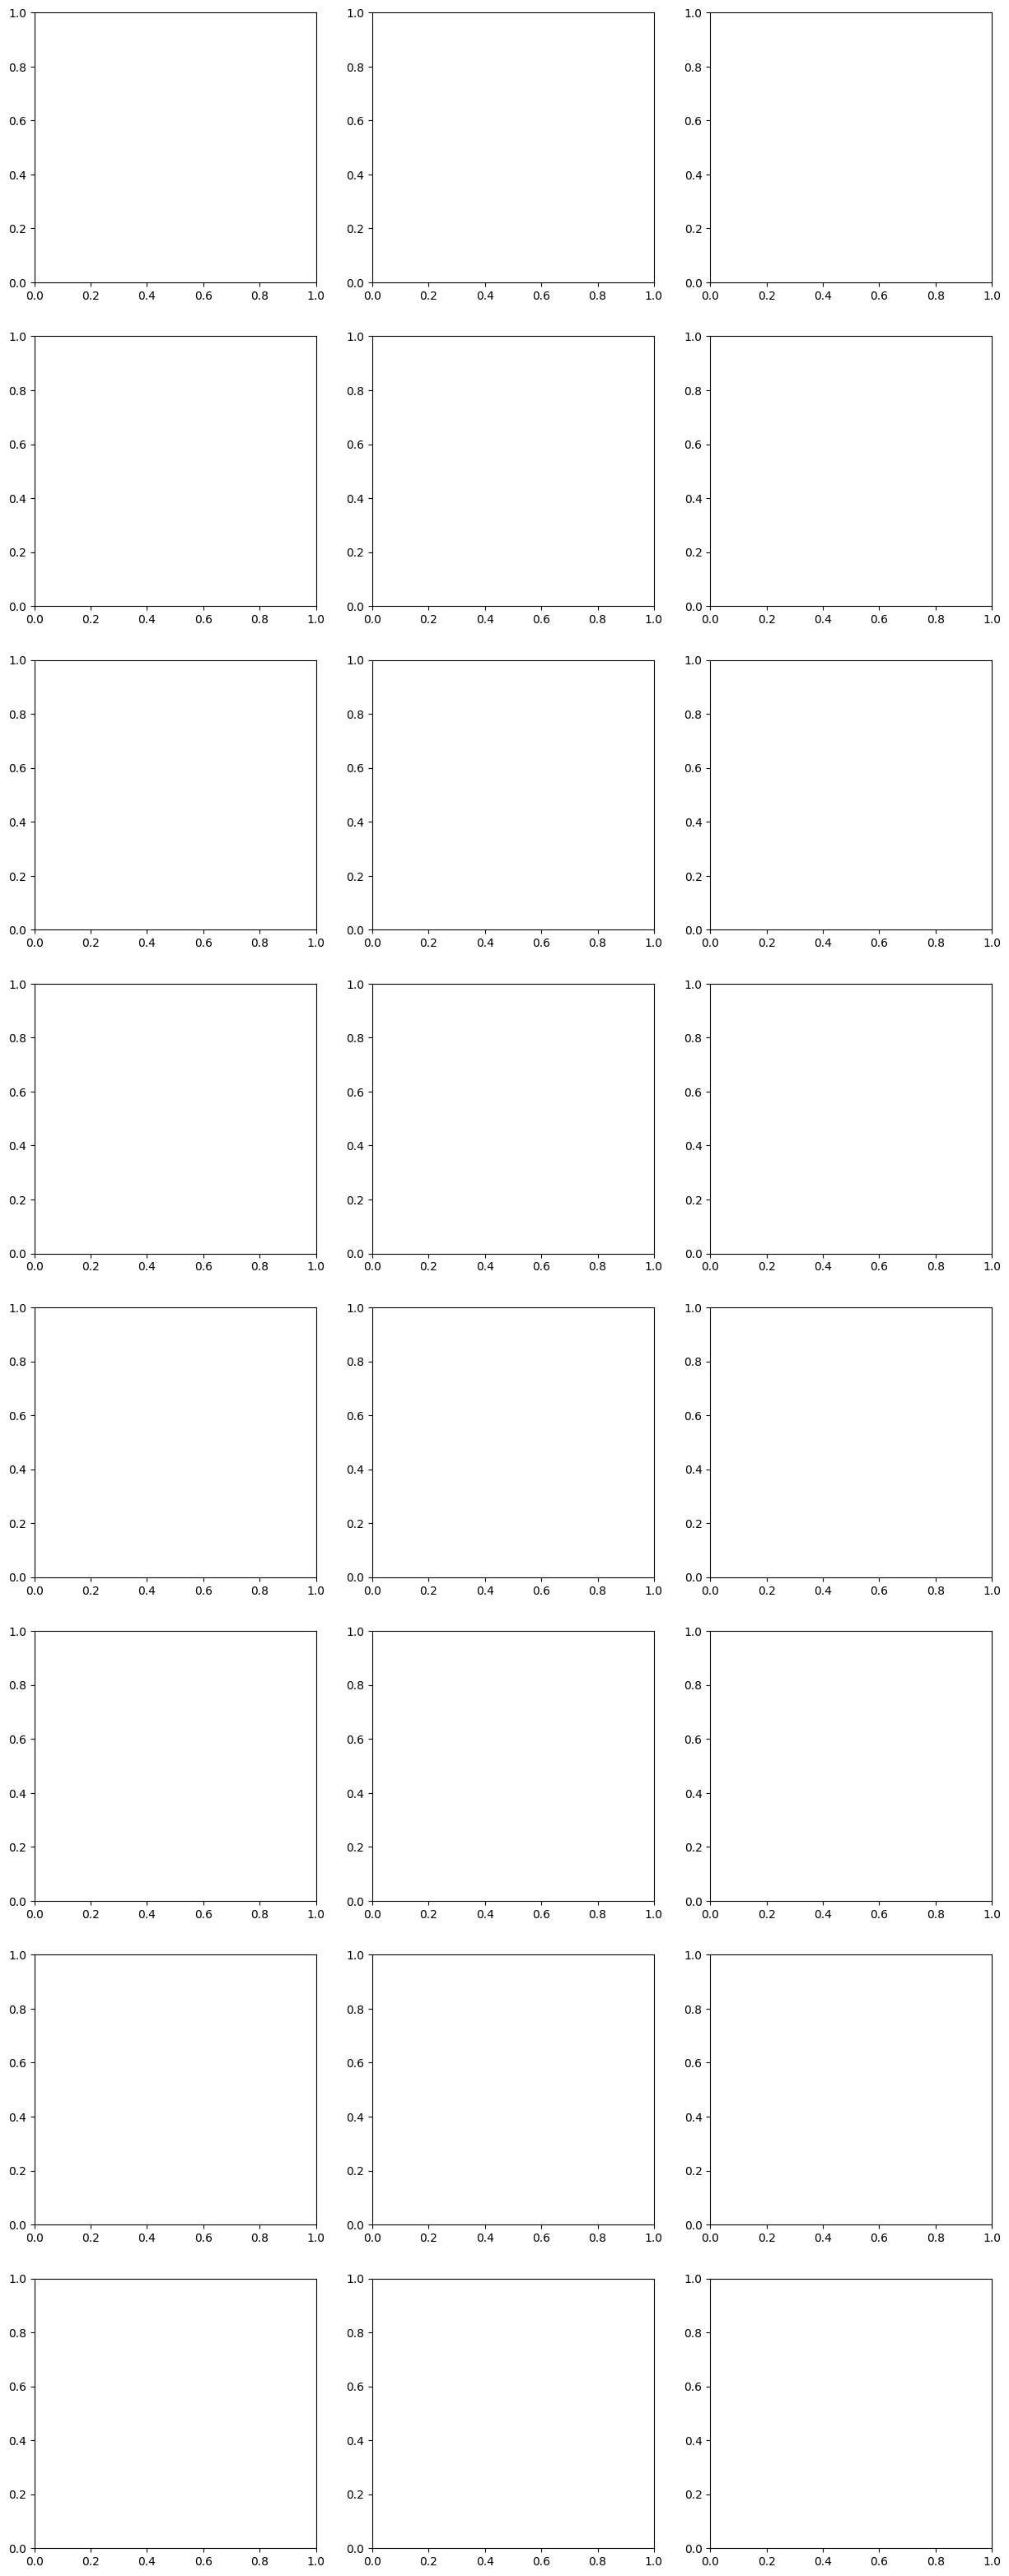

In [89]:
plot_results(model_names = "VGG_UNet")